# Analysis

After running `compare.py` on various sources (chng, nchs, dsew, hhs, quidel), this analysis notebook pinpoints where/when the difference between api and S3 happened.

Read all json files in current dir to a df.

In [145]:
import datetime
import glob
import json

import pandas as pd
import numpy as np
# Create a histogram of the 'signal' column
import matplotlib.pyplot as plt
import matplotlib.dates as md

json_files = glob.glob('./json_files/*.json')
dfs = []

# Read all the JSON files into a list of DataFrames
for json_file in json_files:
    with open(json_file, 'r') as f:
        dfs.append(pd.json_normalize(json.load(f), sep="_"))


# Concatenate all the DataFrames into one
df = pd.concat(dfs, ignore_index=True)
df["diff_num_rows"] = df["diff_num_rows"].fillna(0).astype(int)
df["diff_api_nan_row_count"] = df["diff_api_nan_row_count"].fillna(0).astype(int)
df["diff_s3_nan_row_count"] = df["diff_s3_nan_row_count"].fillna(0).astype(int)
df["diff_val_row_count"] = df["diff_num_rows"] - (df["diff_s3_nan_row_count"] + df["diff_api_nan_row_count"])

# print(df.columns)
# df['time_value'] = df['time_value'].fillna(0).astype(int)


,file_name,source,signal,time_value,geo_type,dif_row_count,s3_row_count,api_row_count,skip,full_diff,diff_num_rows,diff_s3_nan_row_count,diff_api_nan_row_count,reason,diff_val_row_count
0,delphi_hhs_hosp/20191231_hhs_confirmed_admissi...,hhs,confirmed_admissions_covid_1d,20191231,hhs,0.0,6.0,6.0,False,NaN,0,0,0,NaN,0
1,delphi_hhs_hosp/20191231_hhs_confirmed_admissi...,hhs,confirmed_admissions_covid_1d_prop,20191231,hhs,0.0,6.0,6.0,False,NaN,0,0,0,NaN,0
2,delphi_hhs_hosp/20191231_hhs_confirmed_admissi...,hhs,confirmed_admissions_influenza_1d,20191231,hhs,0.0,6.0,6.0,False,NaN,0,0,0,NaN,0
3,delphi_hhs_hosp/20191231_hhs_confirmed_admissi...,hhs,confirmed_admissions_influenza_1d_prop,20191231,hhs,0.0,6.0,6.0,False,NaN,0,0,0,NaN,0
4,delphi_hhs_hosp/20191231_hhs_sum_confirmed_sus...,hhs,sum_confirmed_suspected_admissions_covid_1d,20191231,hhs,0.0,6.0,6.0,False,NaN,0,0,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79428,delphi_dsew_community_profile/20230222_nation_...,dsew-cpr,people_full_vaccinated,20230222,nation,0.0,1.0,1.0,False,NaN,0,0,0,NaN,0
79429,delphi_dsew_community_profile/20230222_state_b...,dsew-cpr,booster_doses_admin_7dav,20230222,state,0.0,56.0,56.0,False,NaN,0,0,0,NaN,0
79430,delphi_dsew_community_profile/20230222_state_d...,dsew-cpr,doses_admin_7dav,20230222,state,0.0,56.0,56.0,False,NaN,0,0,0,NaN,0
79431,delphi_dsew_community_profile/20230222_state_p...,dsew-cpr,people_booster_doses,20230222,state,0.0,56.0,56.0,False,NaN,0,0,0,NaN,0


In [128]:
def generate_diff_plot(source, df_match, df_diff):
    plt.figure(figsize=(30, 10))
    plt.title(f'Count of type of differences for {source} signals', fontsize=50)

    df_match = df_match[["signal", "s3_row_count"]].groupby(["signal"]).sum().to_dict()["s3_row_count"]
    api_nan = df_diff[["signal", "diff_api_nan_row_count"]].groupby(["signal"]).sum().to_dict()["diff_api_nan_row_count"]
    s3_nan = df_diff[["signal", "diff_s3_nan_row_count"]].groupby(["signal"]).sum().to_dict()["diff_s3_nan_row_count"]
    val_diff = df_diff[["signal", "diff_val_row_count"]].groupby(["signal"]).sum().to_dict()["diff_val_row_count"]
    
    match_signal, match_data = zip(*(sorted(df_match.items())))
    api_signals, api_data  = zip(*(sorted(api_nan.items())))
    s3_signals, s3_data =  zip(*(sorted(s3_nan.items())))
    val_signals, val_data =  zip(*(sorted(val_diff.items())))

    bottom = np.zeros(len(api_signals))
    # plt.bar(match_signal, match_data, bottom=bottom, label='matching', width=0.5)
    plt.bar(val_signals, val_data, bottom=bottom, label='val diff', width=0.5)
    plt.bar(api_signals, api_data, bottom=bottom+val_data, label='nan api', width=0.5,)
    plt.bar(s3_signals, s3_data, bottom=bottom+val_data+api_data, label='nan s3', width=0.5,)
        
    plt.legend()
    max_limit = int(max([sum(tup) for tup in (zip(api_data, s3_data,val_data))]) * 1.5)

    plt.ylim(top=max_limit)
    # Set the labels and title
    plt.xlabel('Signals', fontsize=20)
    plt.ylabel('Number of rows', fontsize=30)

    plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
    plt.tick_params(axis='y', which='major', labelsize=25, width=0.5)
    plt.tick_params(axis='x', which='major',  labelsize=25)
    # Display the plot
    plt.show()
    

In [36]:
nchs = df[df["source"]=="nchs-mortality"].copy(deep=True)
nchs_diff = nchs[(nchs['dif_row_count']!=0) & (nchs['skip']==False)]
nchs_match = nchs[nchs['dif_row_count']==0]
generate_diff_plot("nchs-mortality", nchs_match, nchs_diff)

,file_name,source,signal,time_value,geo_type,dif_row_count,s3_row_count,api_row_count,skip,full_diff,diff_num_rows,diff_s3_nan_row_count,diff_api_nan_row_count,diff_val_row_count
0,delphi_hhs_hosp/20191231_hhs_confirmed_admissi...,hhs,confirmed_admissions_covid_1d,20191231,hhs,0.0,6,6,False,NaN,0.0,0.0,0.0,0.0
1,delphi_hhs_hosp/20191231_hhs_confirmed_admissi...,hhs,confirmed_admissions_covid_1d_prop,20191231,hhs,0.0,6,6,False,NaN,0.0,0.0,0.0,0.0
2,delphi_hhs_hosp/20191231_hhs_confirmed_admissi...,hhs,confirmed_admissions_influenza_1d,20191231,hhs,0.0,6,6,False,NaN,0.0,0.0,0.0,0.0
3,delphi_hhs_hosp/20191231_hhs_confirmed_admissi...,hhs,confirmed_admissions_influenza_1d_prop,20191231,hhs,0.0,6,6,False,NaN,0.0,0.0,0.0,0.0
4,delphi_hhs_hosp/20191231_hhs_sum_confirmed_sus...,hhs,sum_confirmed_suspected_admissions_covid_1d,20191231,hhs,0.0,6,6,False,NaN,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72382,delphi_dsew_community_profile/20230222_nation_...,dsew-cpr,people_full_vaccinated,20230222,nation,0.0,1,1,False,NaN,0.0,0.0,0.0,0.0
72383,delphi_dsew_community_profile/20230222_state_b...,dsew-cpr,booster_doses_admin_7dav,20230222,state,0.0,56,56,False,NaN,0.0,0.0,0.0,0.0
72384,delphi_dsew_community_profile/20230222_state_d...,dsew-cpr,doses_admin_7dav,20230222,state,0.0,56,56,False,NaN,0.0,0.0,0.0,0.0
72385,delphi_dsew_community_profile/20230222_state_p...,dsew-cpr,people_booster_doses,20230222,state,0.0,56,56,False,NaN,0.0,0.0,0.0,0.0


In [105]:
def generate_diff_over_time_plot(source, df_diff):
    # Create a plot
    plt.figure(figsize=(20, 5))
        
    api_nan = df_diff[["time_value", "diff_api_nan_row_count"]].groupby(["time_value"]).sum().to_dict()["diff_api_nan_row_count"]
    s3_nan = df_diff[["time_value", "diff_s3_nan_row_count"]].groupby(["time_value"]).sum().to_dict()["diff_s3_nan_row_count"]
    val_diff = df_diff[["time_value", "diff_val_row_count"]].groupby(["time_value"]).sum().to_dict()["diff_val_row_count"]
    
    api_signals, api_data  = zip(*(sorted(api_nan.items())))
    s3_signals, s3_data =  zip(*(sorted(s3_nan.items())))
    val_signals, val_data =  zip(*(sorted(val_diff.items())))

    bottom = np.zeros(len(api_signals))

    plt.bar(val_signals, val_data, bottom=bottom, label='nan api', width=datetime.timedelta(days=1), color='blue')
    plt.bar(api_signals, api_data, bottom=bottom+val_data, label='nan s3', width=datetime.timedelta(days=1),
            color='orange')
    plt.bar(s3_signals, s3_data, bottom=bottom+val_data+api_data,  label='val diff', width=datetime.timedelta(days=1), color='green')
    
    # Set the labels and title
    plt.xlabel('Time Value')
    plt.ylabel('Number of Row differences', fontsize=20)
    max_limit = int(max([sum(tup) for tup in (zip(api_data, val_data, s3_data))]) * 1.5)
    # plt.ylim(max_limit)
    # print(max_limit)
    plt.title(f'Number of Row differences over Time ({source})', fontsize=20)
    plt.legend()
    # Display the plot
    plt.show()
    

## General Analysis
After missingness is taken into account, less than 10% of the files have differences.

In [ ]:
print('number of s3 csv files processed by compare.py',len(df))
print('number of s3 csv files with differences found',len(df[df['dif_row_count']!=0]))

## Specific Indicators
#### 1. Quidel
Vast majority of quidel s3 files have all rows matching api equivalent.
Smoothed signals have more differences than non-smoothed signals.
2 big spikes in 2022 and throughout mid 2023. 

In [ ]:
quidel = df[df["source"]=="quidel"].copy(deep=True)
# quidel["s3_nan_row_count"] = quidel["diff"].apply(lambda x:x['s3_nan_row_count'])
# quidel["api_nan_row_count"] = quidel["diff"].apply(lambda x:x['api_nan_row_count'])

In [ ]:
print(f"Files with mismatched rows: {len(quidel[quidel['dif_row_count']!=0])}")
print(f"Files processed: {len(quidel)}")
print(f"Rate of problematic files: {len(quidel[quidel['dif_row_count']!=0])/len(quidel)}")

In [ ]:
quidel_match = quidel[quidel['dif_row_count']==0]
quidel_diff = quidel[quidel['dif_row_count']!=0]
generate_diff_plot("quidel", quidel_match, quidel_diff)

In [ ]:
quidel_diff['time_value'] = pd.to_datetime(quidel_diff['time_value'], format='%Y%m%d')
generate_diff_over_time_plot("quidel", quidel_diff)

#### 2. nchs

Note: This indicator uses its own version of the archive differ, which outputs a different csv structure, causing wrong result in previous analysis.

With that and missingness taken into account, this time we see the indicator has 13% of files being different from its equivalent api result, with the biggest spike in mid 2023.

In [146]:
nchs = df[df["source"]=="nchs-mortality"].copy(deep=True)
nchs_diff = nchs[(nchs['dif_row_count']!=0)& (nchs['skip']==False)]
nchs_match = nchs[nchs['dif_row_count']==0 & (nchs['skip']==False)]

nan_api_filter = (nchs_diff["diff_api_nan_row_count"] > 0)
nan_s3_filter = (nchs_diff["diff_s3_nan_row_count"] > 0)
diff_val_filter = (nchs_diff["diff_val_row_count"] > 0)

,file_name,source,signal,time_value,geo_type,dif_row_count,s3_row_count,api_row_count,skip,full_diff,diff_num_rows,diff_s3_nan_row_count,diff_api_nan_row_count,reason,diff_val_row_count
56736,nchs_mortality/weekly_202005_state_wip_deaths_...,nchs-mortality,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,0,0,0,wip in signal name,0
56737,nchs_mortality/weekly_202005_state_wip_deaths_...,nchs-mortality,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,0,0,0,wip in signal name,0
56738,nchs_mortality/weekly_202005_state_wip_deaths_...,nchs-mortality,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,0,0,0,wip in signal name,0
56739,nchs_mortality/weekly_202005_state_wip_deaths_...,nchs-mortality,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,0,0,0,wip in signal name,0
56740,nchs_mortality/weekly_202005_state_wip_deaths_...,nchs-mortality,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,0,0,0,wip in signal name,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63777,nchs_mortality/weekly_202440_state_deaths_perc...,nchs-mortality,deaths_percent_of_expected,202440,state,0.0,52.0,52.0,False,NaN,0,0,0,NaN,0
63778,nchs_mortality/weekly_202440_state_deaths_pneu...,nchs-mortality,deaths_pneumonia_notflu_incidence_num,202440,state,0.0,35.0,35.0,False,NaN,0,0,0,NaN,0
63779,nchs_mortality/weekly_202440_state_deaths_pneu...,nchs-mortality,deaths_pneumonia_notflu_incidence_prop,202440,state,0.0,35.0,35.0,False,NaN,0,0,0,NaN,0
63780,nchs_mortality/weekly_202440_state_deaths_pneu...,nchs-mortality,deaths_pneumonia_or_flu_or_covid_incidence_num,202440,state,0.0,39.0,39.0,False,NaN,0,0,0,NaN,0


In [148]:
print(f"Files with mismatched rows: {len(nchs[(nchs['dif_row_count']!=0)])}")
print(f"Files processed: {len(nchs)}")
print(f"Rate of problematic files: {len(nchs[nchs['dif_row_count']!=0])/len(nchs)}")
print(f"Total mismatched rows: {nchs_diff['diff_num_rows'].sum()}")
print(f"    S3 Rows with NaN: {nchs_diff[nan_s3_filter]['diff_s3_nan_row_count'].sum()}")
print(f"    Api Rows with NaN: {nchs_diff[nan_api_filter]['diff_api_nan_row_count'].sum()}")
print(f"    Rows with diff vales: {nchs_diff[diff_val_filter]['diff_val_row_count'].sum()}")


Files with mismatched rows: 953
Files processed: 7046
Rate of problematic files: 0.1352540448481408
Total mismatched rows: 712
    S3 Rows with NaN: 46
    Api Rows with NaN: 96
    Rows with diff vales: 570


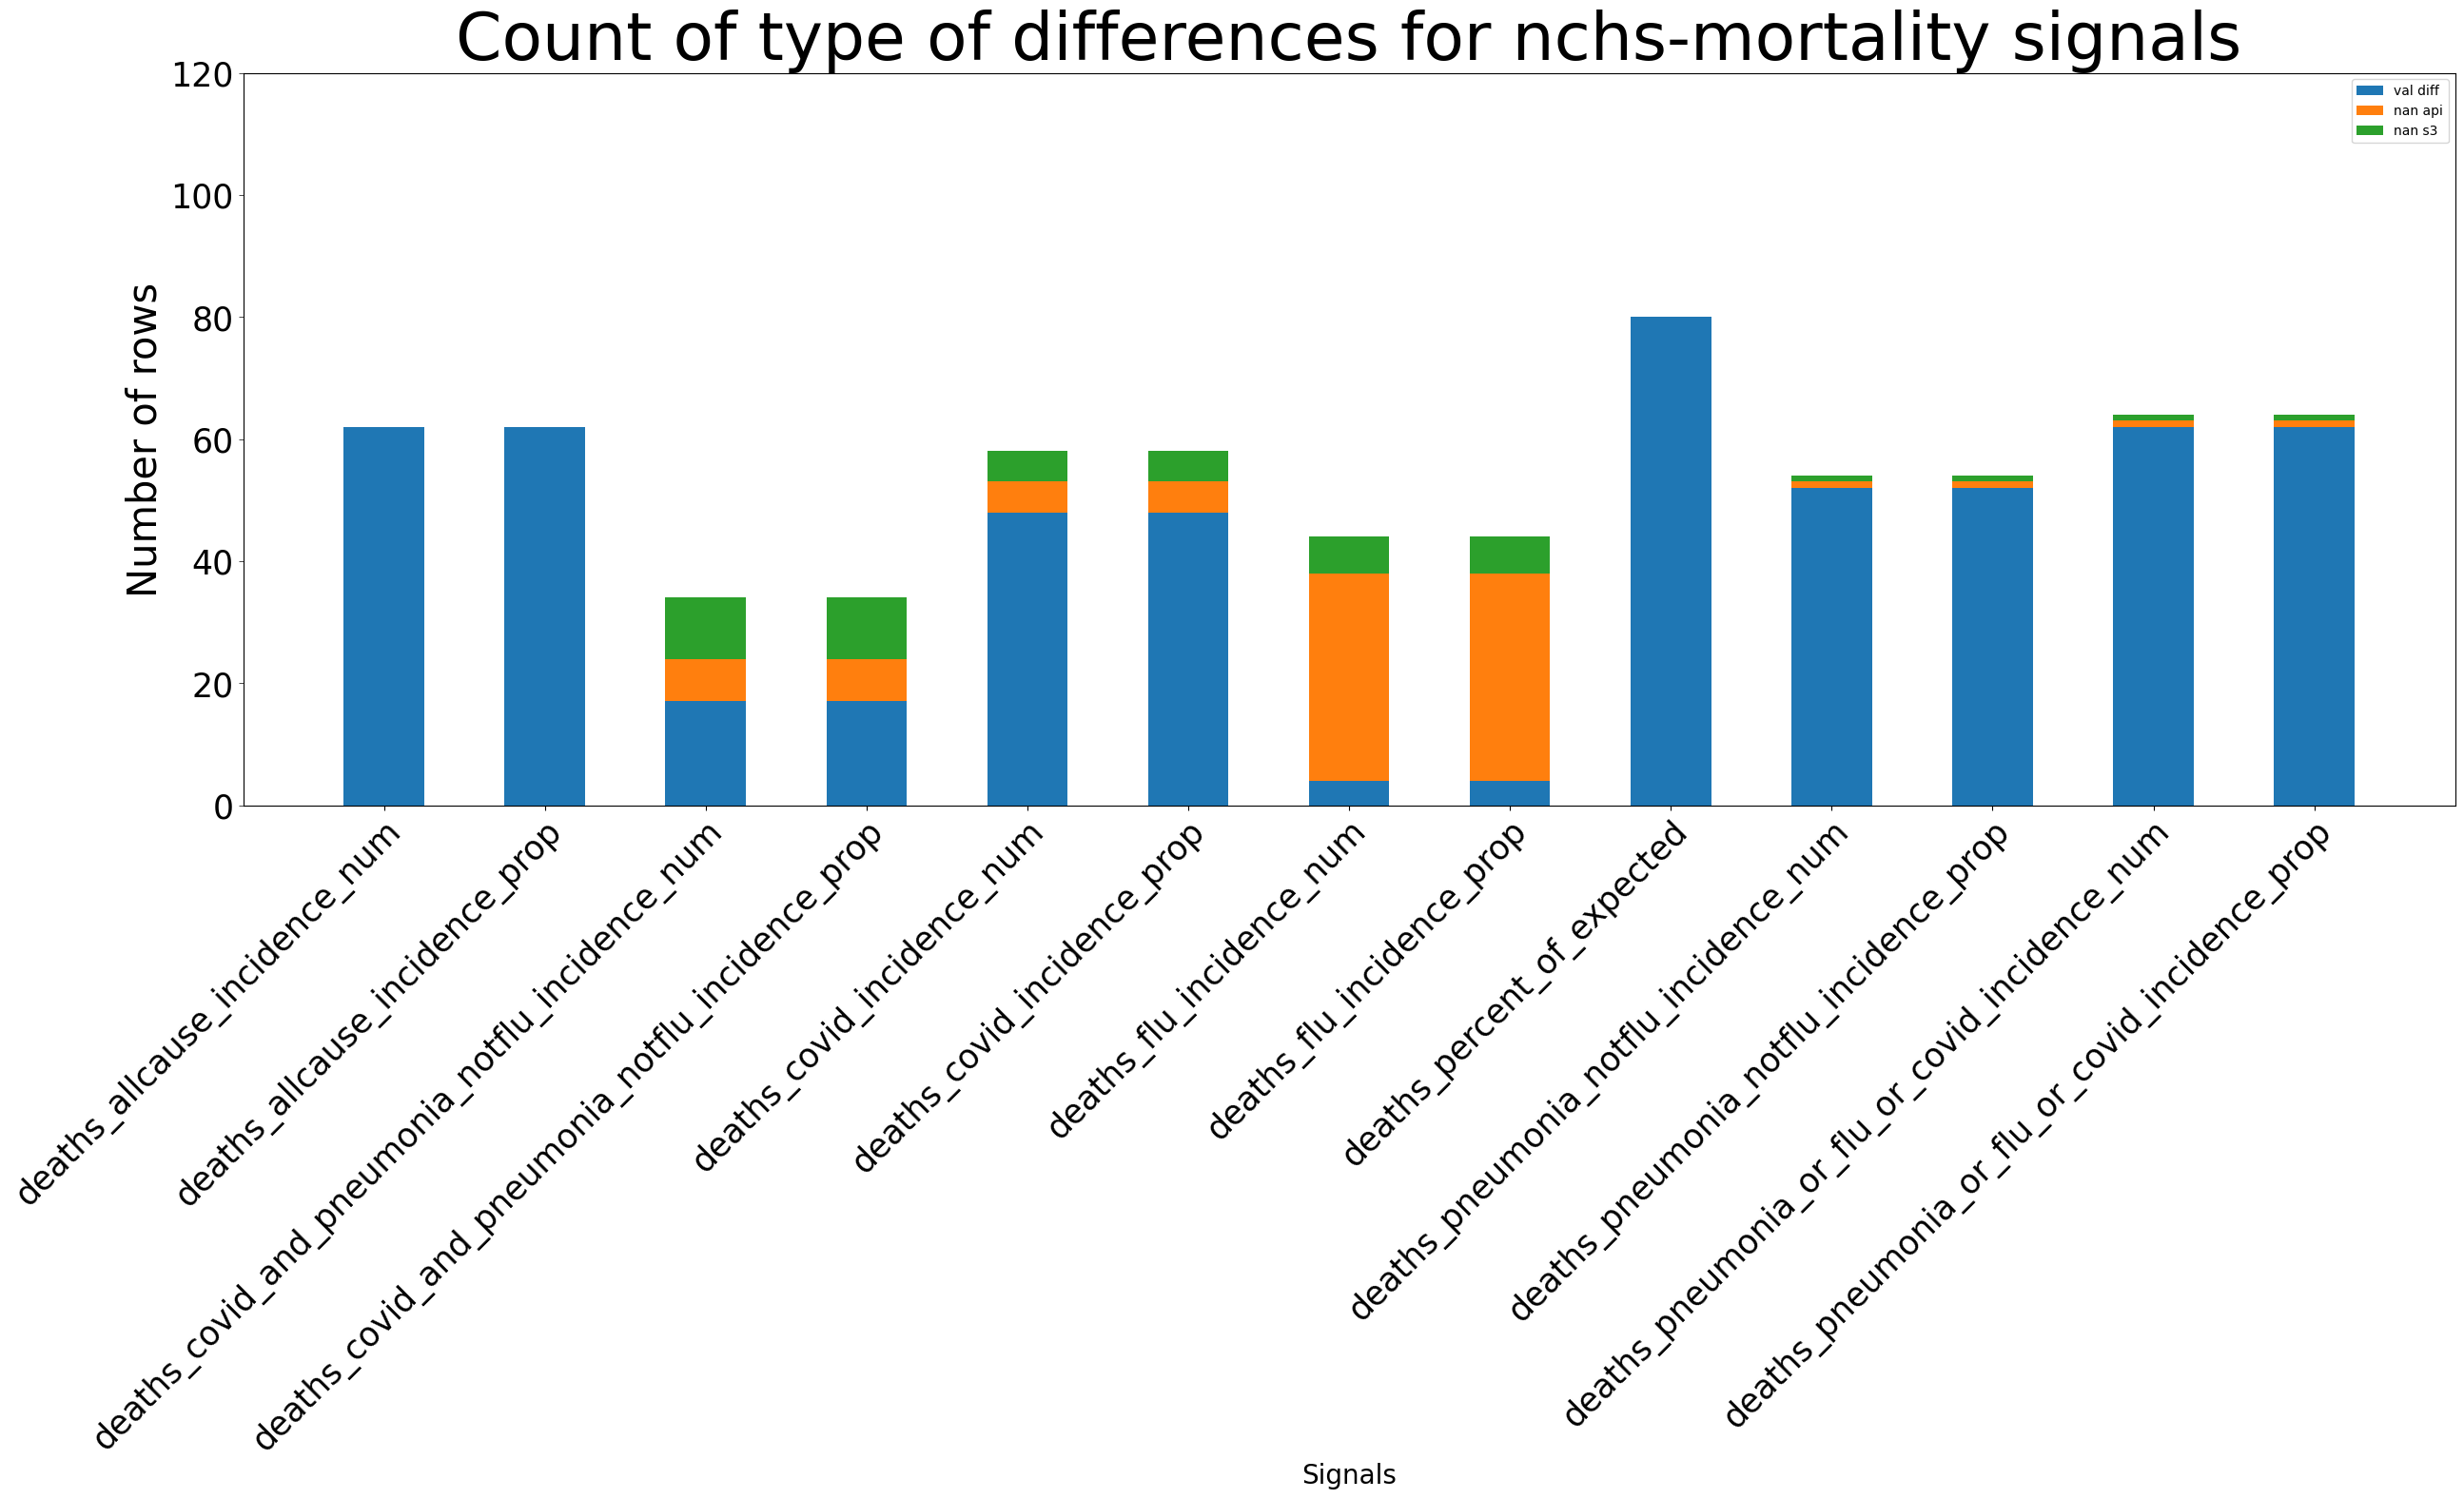

In [149]:
nchs_diff = nchs[(nchs['dif_row_count']!=0) & (nchs['skip']==False)]
nchs_match = nchs[nchs['dif_row_count']==0]
generate_diff_plot("nchs-mortality", nchs_match, nchs_diff)


In [ ]:
nchs_diff['time_value'] = nchs_diff['time_value'].astype(str) + '0'
# Convert 'time_value' to datetime
nchs_diff['time_value'] = pd.to_datetime(nchs_diff['time_value'], format='%Y%U%w')
generate_diff_over_time_plot("nchs-mortality", nchs_diff)

#### 3. chng

Around 30% of files have some differences from api.
Two major periods of mismatch:
- Mid 2020 to late 2021
- mid 2023 when the big contract patch happened.

In [ ]:
chng = df[df["source"]=="chng"]

In [ ]:
print(f"Files with mismatched rows: {len(chng[chng['dif_row_count']!=0])}")
print(f"Files processed: {len(chng)}")
print(f"Rate of problematic files: {len(chng[chng['dif_row_count']!=0])/len(chng)}")

In [ ]:
chng_diff = chng[chng['dif_row_count']!=0]
chng_match = chng[chng['dif_row_count']==0]

generate_diff_plot("chng", chng_match, chng_diff)

In [ ]:
chng['time_value'] = pd.to_datetime(chng['time_value'], format='%Y%m%d')
generate_diff_over_time_plot("chng", chng_diff)

#### 4.hhs
Vast majority of files for this indicator match api.
Late 2023 is when we see a spike of mismatch, right before the indicator got retired.


In [89]:
hhs= df[df["source"]=="hhs"].copy(deep=True)
hhs_diff = hhs[(hhs['dif_row_count']!=0)& (hhs['skip']==False)]
hhs_match = hhs[hhs['dif_row_count']==0 & (hhs['skip']==False)]


nan_api_filter = (hhs["diff_api_nan_row_count"] > 0)
nan_s3_filter = (hhs["diff_s3_nan_row_count"] > 0)
diff_val_filter = (hhs["diff_val_row_count"] > 0)


In [61]:
print(f"Files with mismatched rows: {len(hhs[hhs['dif_row_count']!=0])}")
print(f"Files processed: {len(hhs)}")
print(f"Rate of problematic files: {len(hhs[hhs['dif_row_count']!=0])/len(hhs)}")
print(f"Total mismatched rows: {hhs['diff_num_rows'].sum()}")
print(f"    S3 Rows with NaN: {hhs[nan_s3_filter]['diff_s3_nan_row_count'].sum()}")
print(f"    Api Rows with NaN: {hhs[nan_api_filter]['diff_api_nan_row_count'].sum()}")
print(f"    Rows with diff vales: {hhs[diff_val_filter]['diff_val_row_count'].sum()}")


Files with mismatched rows: 796
Files processed: 56736
Rate of problematic files: 0.014029892836999435
Total mismatched rows: 2952
    S3 Rows with NaN: 0
    Api Rows with NaN: 68
    Rows with diff vales: 2884


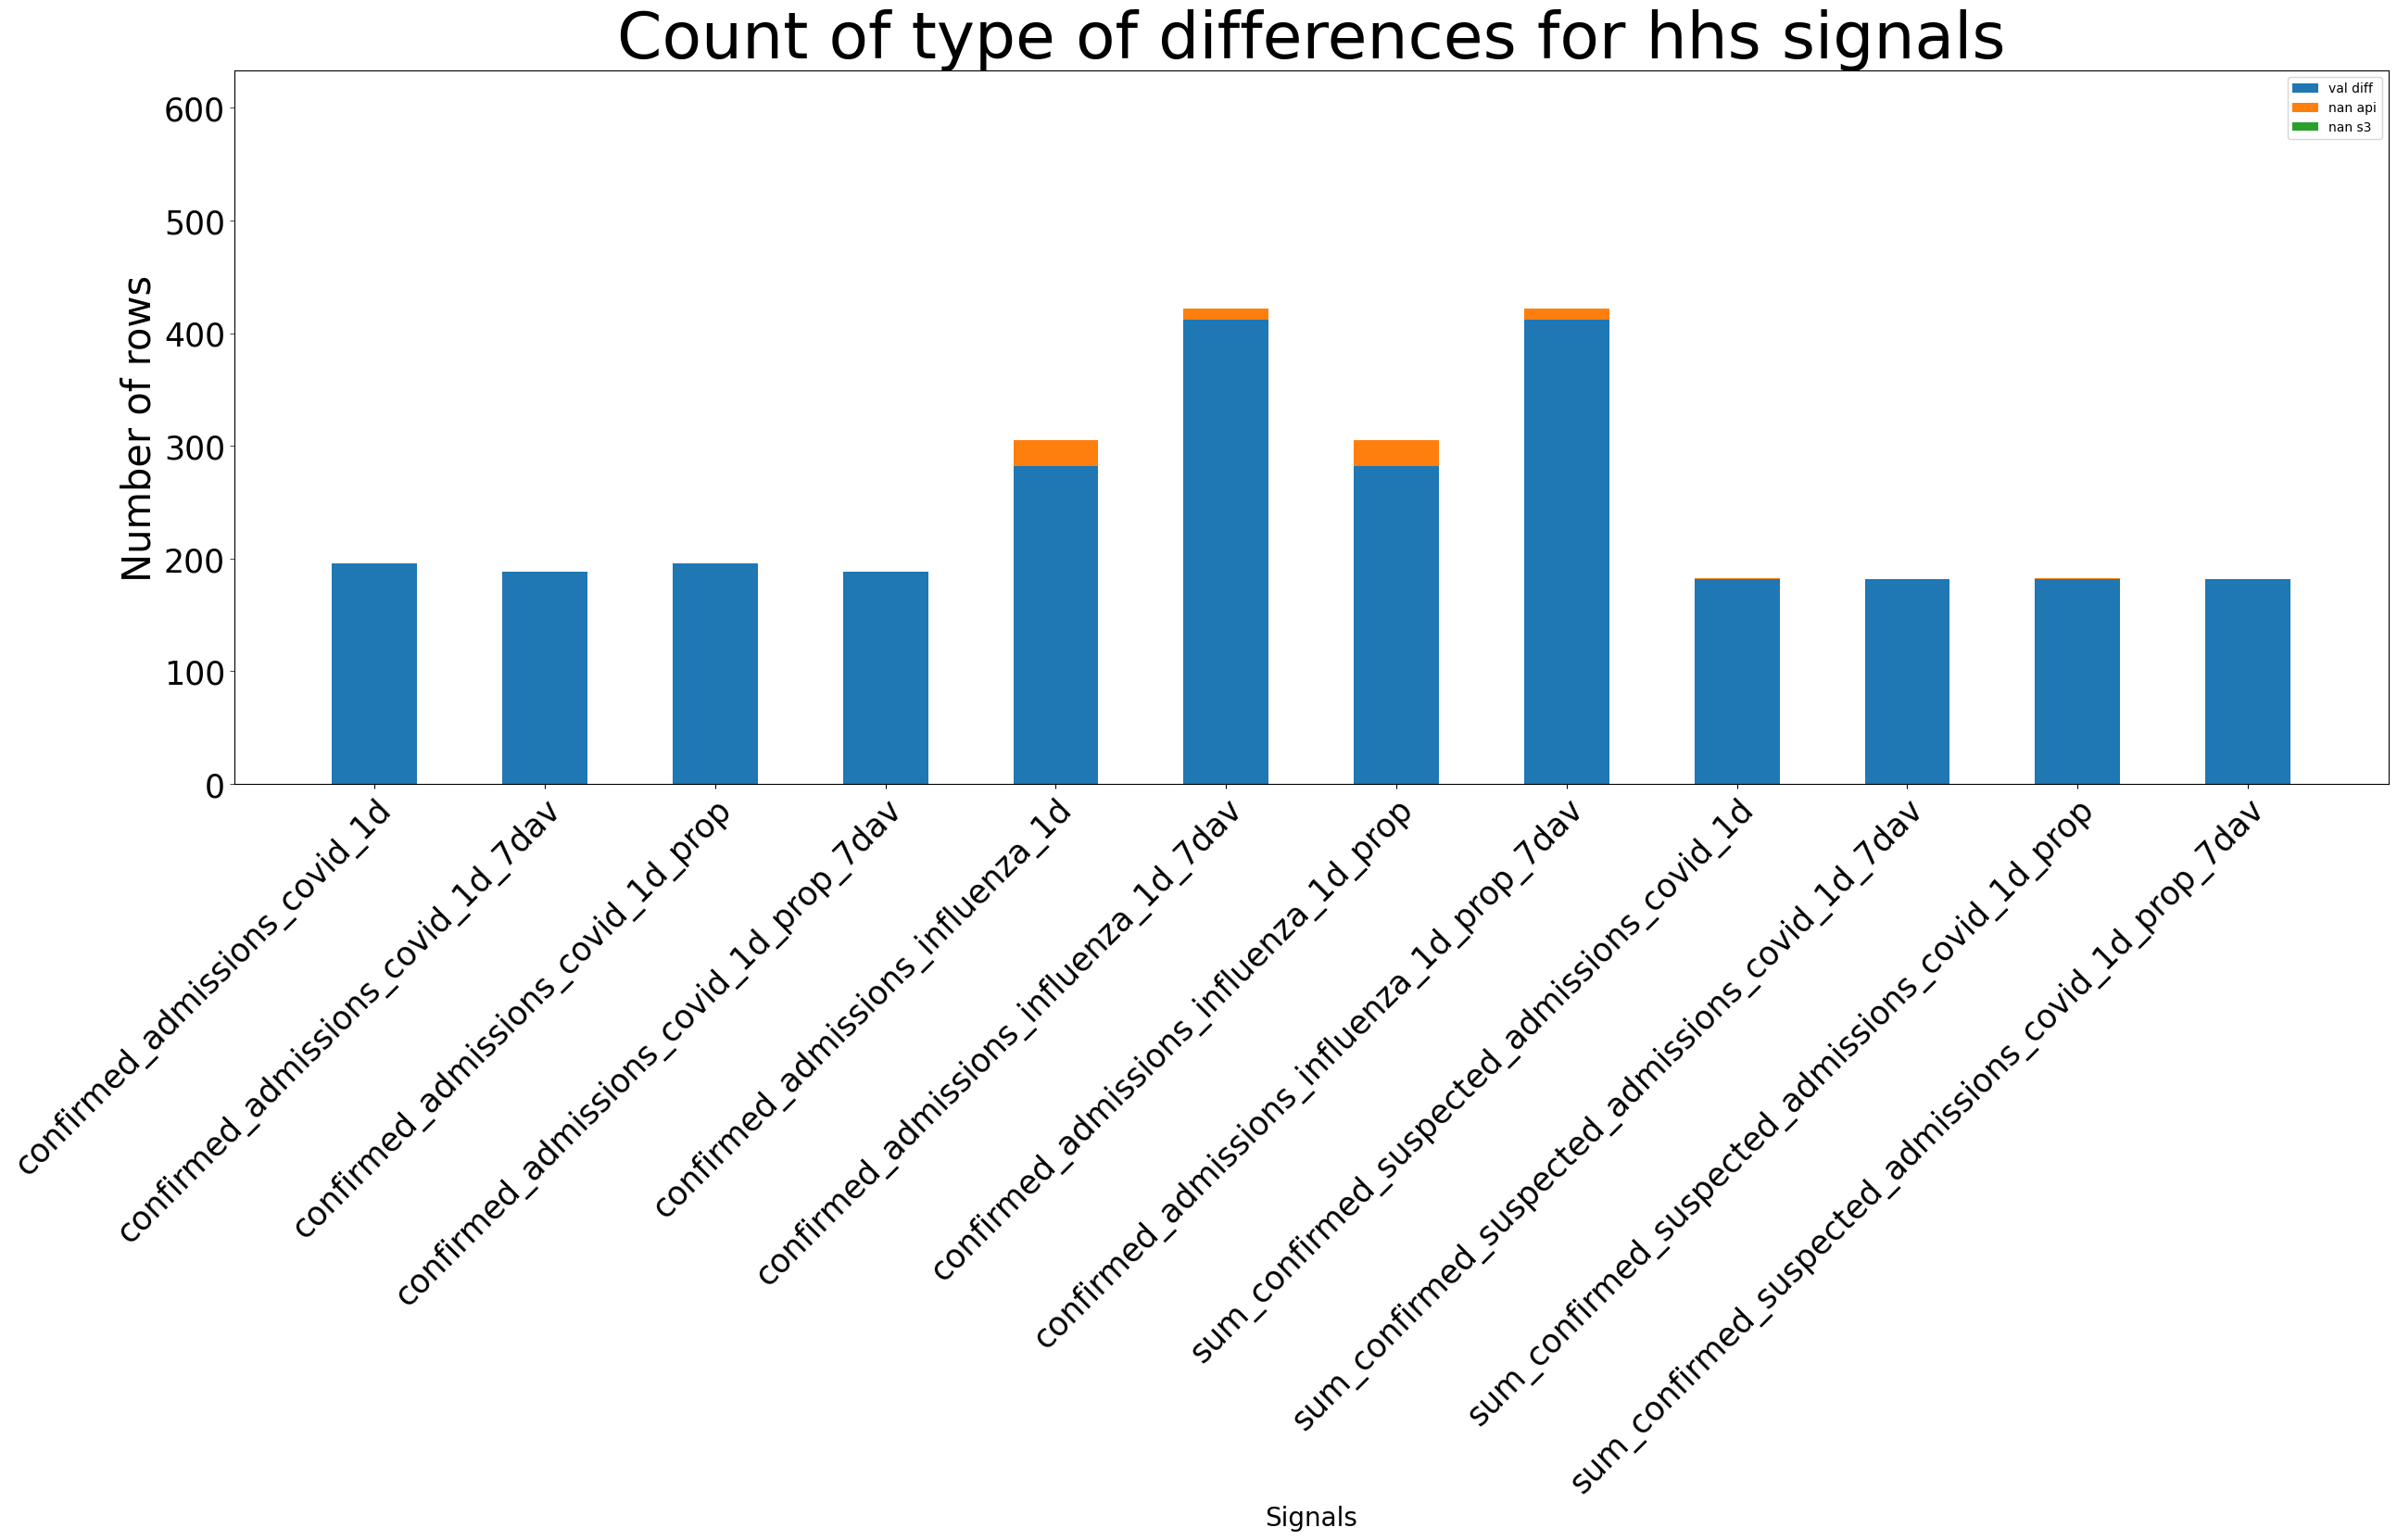

In [123]:
hhs_diff = hhs[hhs['dif_row_count']!=0]
hhs_match = hhs[hhs['dif_row_count']==0]

generate_diff_plot("hhs", hhs_match, hhs_diff)


/var/folders/s6/ytv8f9z11q32lhh5ksxrp_tm0000gn/T/ipykernel_45000/3056530839.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hhs_diff['time_value'] = pd.to_datetime(hhs_diff['time_value'], format='%Y%m%d')


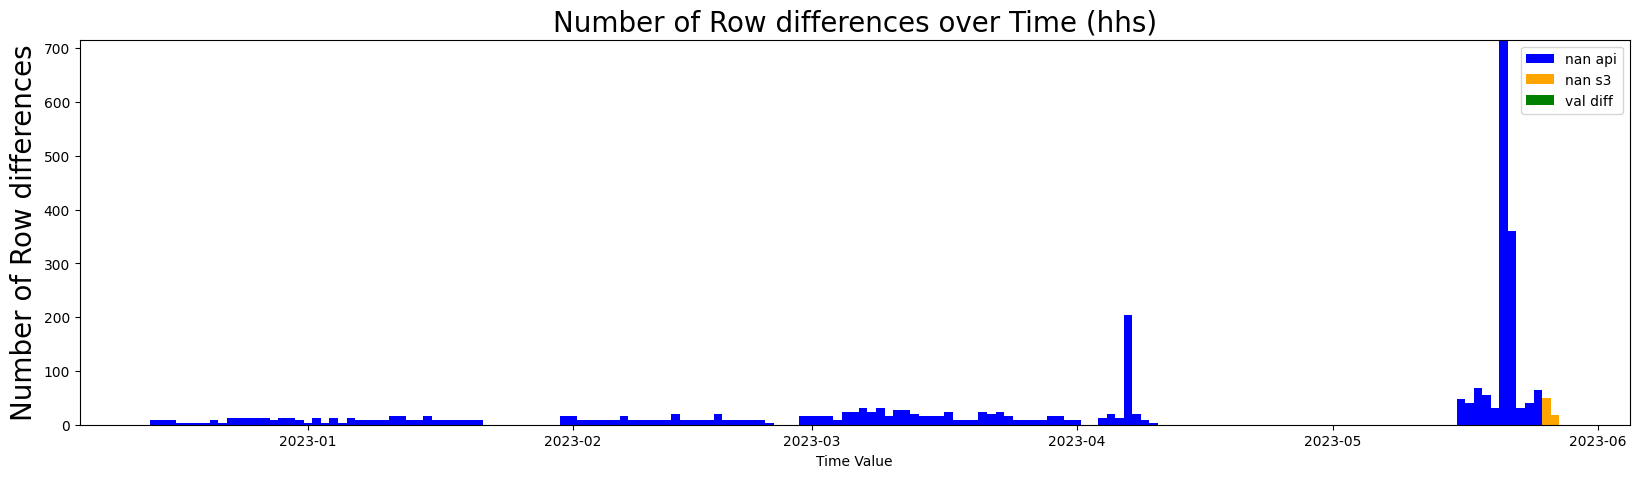

In [124]:
# Convert 'time_value' to datetime
hhs_diff['time_value'] = pd.to_datetime(hhs_diff['time_value'], format='%Y%m%d')
generate_diff_over_time_plot("hhs", hhs_diff)

#### 5. dsew
Vast majority of the files all match. 

In [112]:
dsew = df[df["source"]=="dsew-cpr"].copy(deep=True)
dsew_diff = dsew[(dsew['dif_row_count']!=0)& (dsew['skip']==False)]
dsew_match = dsew[dsew['dif_row_count']==0 & (dsew['skip']==False)]


nan_api_filter = (dsew["diff_api_nan_row_count"] > 0)
nan_s3_filter = (dsew["diff_s3_nan_row_count"] > 0)
diff_val_filter = (dsew["diff_val_row_count"] > 0)

In [113]:
print(f"Files with mismatched rows: {len(dsew[dsew['dif_row_count']!=0])}")
print(f"Files processed: {len(dsew)}")
print(f"Rate of problematic files: {len(dsew[dsew['dif_row_count']!=0])/len(hhs)}")
print(f"Total mismatched rows: {dsew['diff_num_rows'].sum()}")
print(f"    S3 Rows with NaN: {dsew[nan_s3_filter]['diff_s3_nan_row_count'].sum()}")
print(f"    Api Rows with NaN: {dsew[nan_api_filter]['diff_api_nan_row_count'].sum()}")
print(f"    Rows with diff vales: {dsew[diff_val_filter]['diff_val_row_count'].sum()}")


Files with mismatched rows: 52
Files processed: 15651
Rate of problematic files: 0.0009165256627185561
Total mismatched rows: 15947
    S3 Rows with NaN: 8
    Api Rows with NaN: 0
    Rows with diff vales: 15939


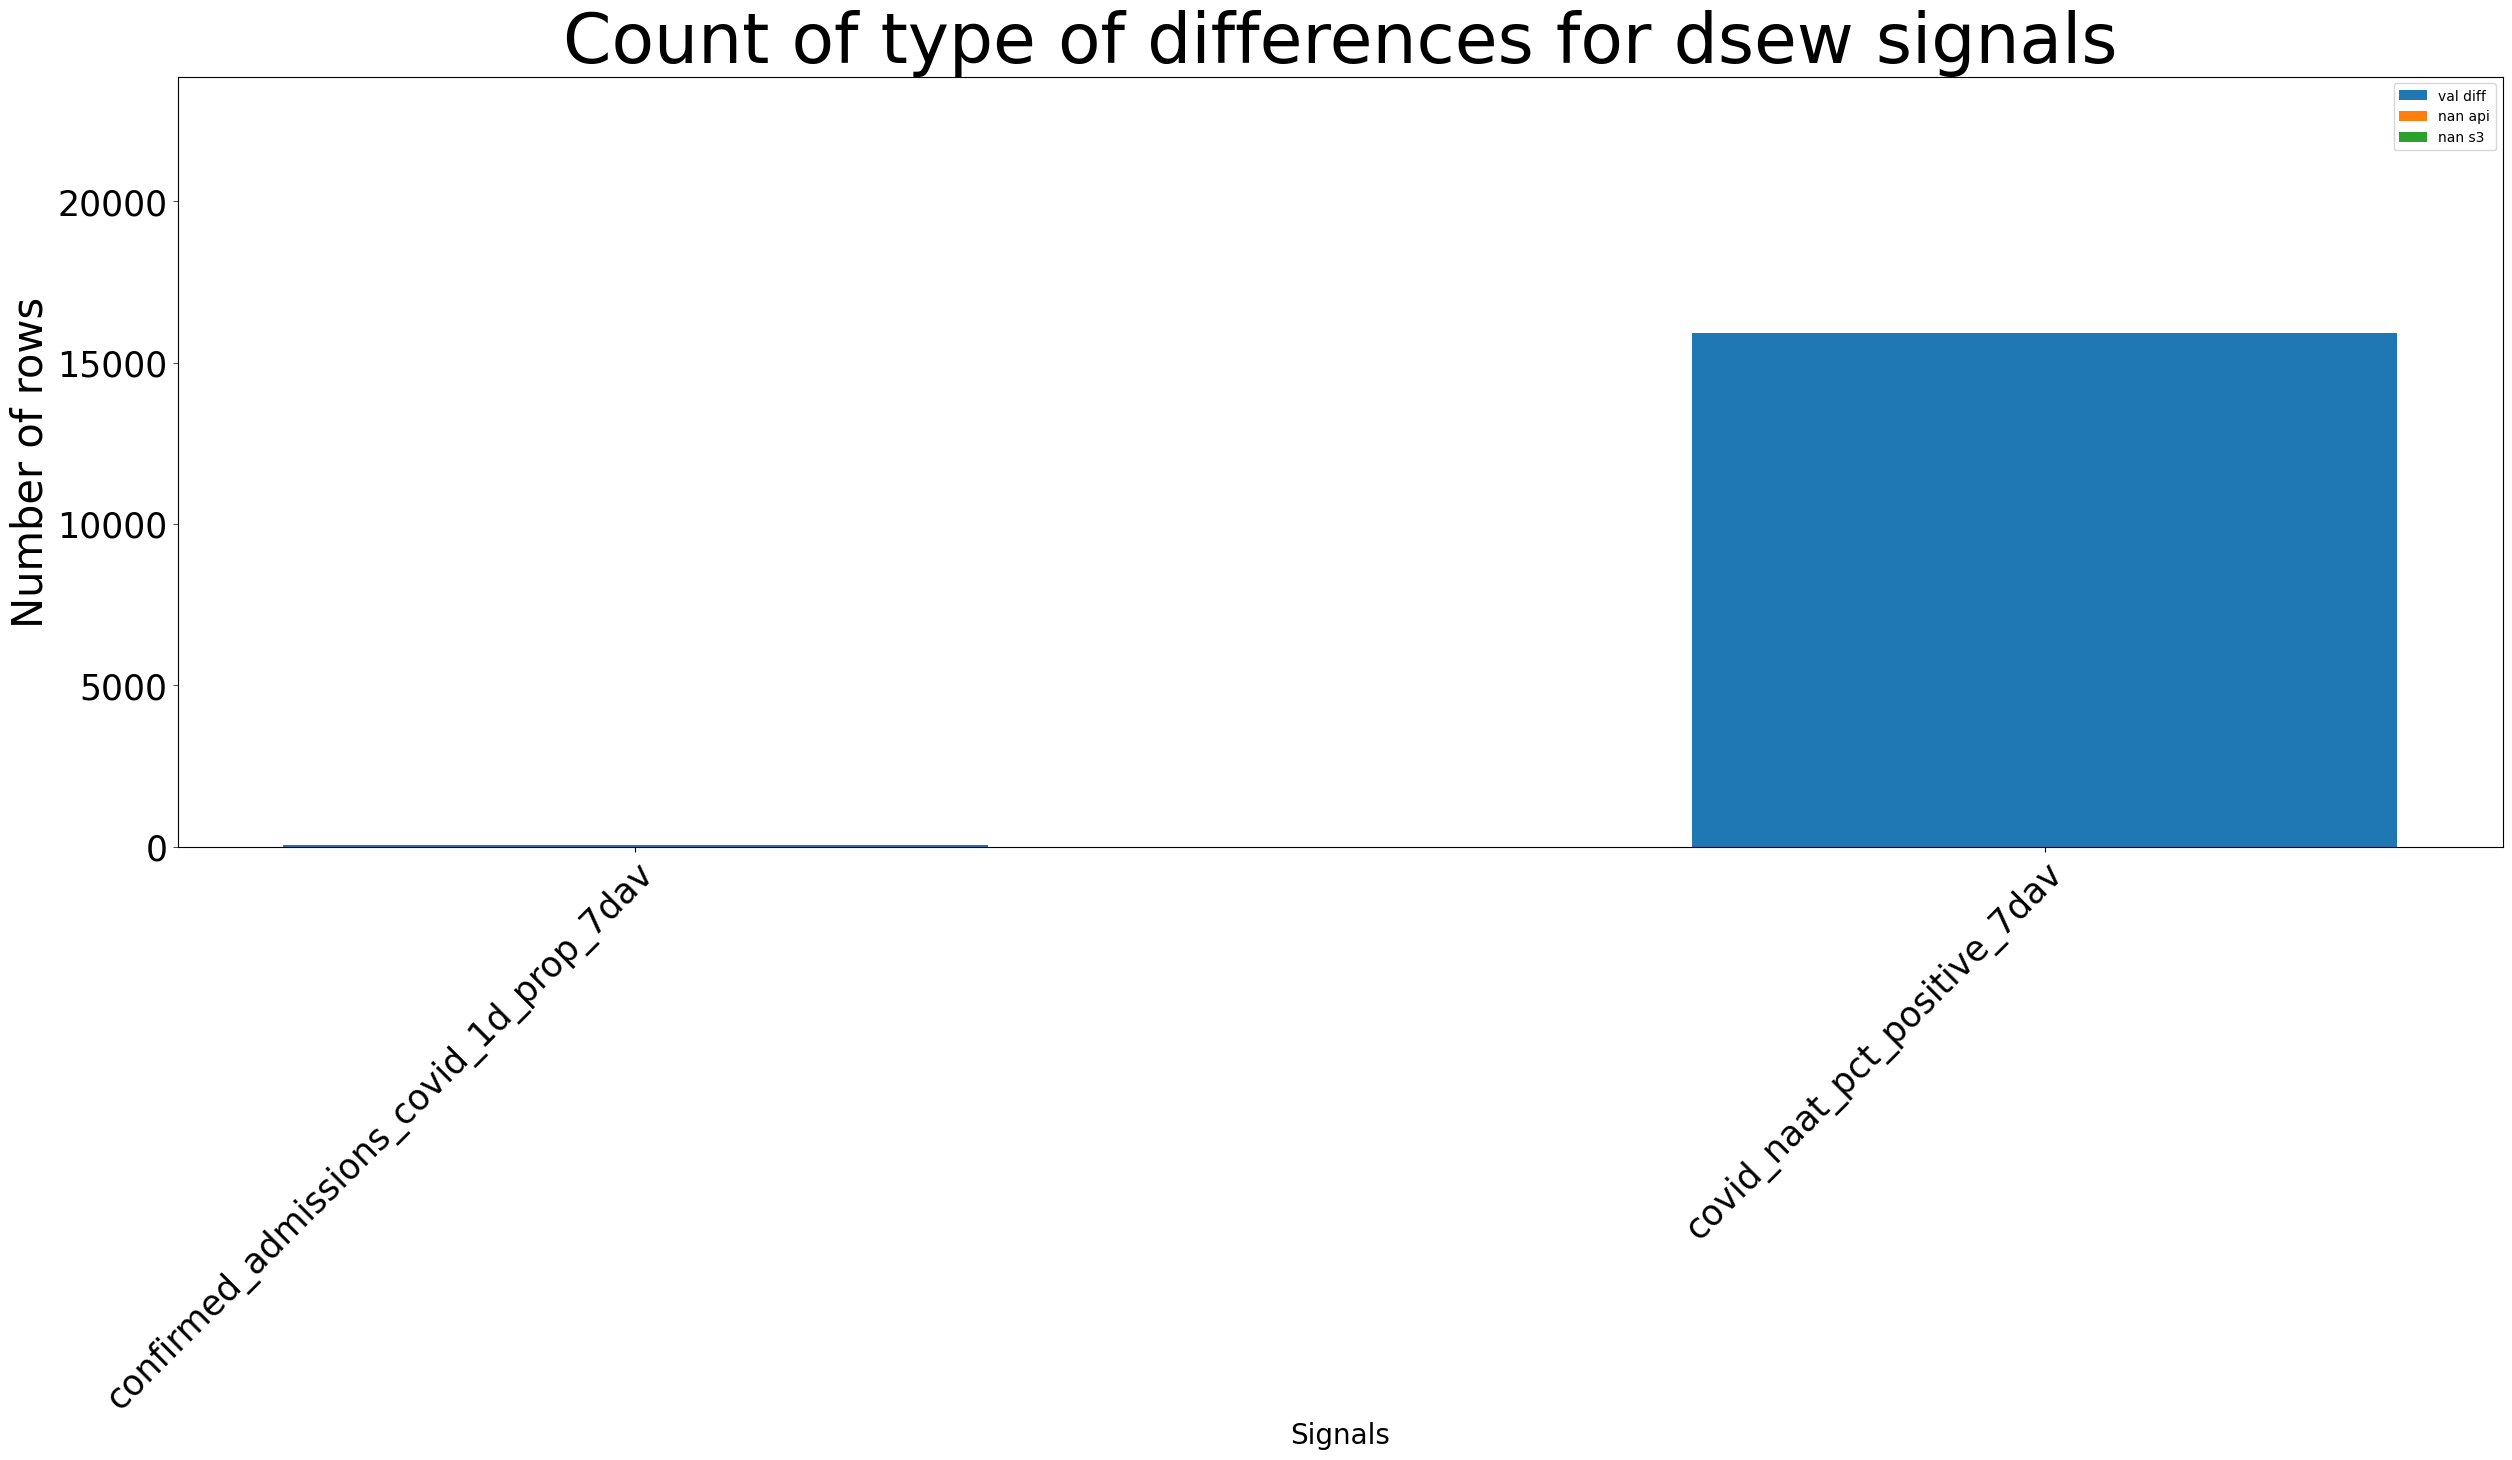

In [129]:
dsew_diff = dsew[dsew['dif_row_count']!=0]
dsew_match = dsew[dsew['dif_row_count']==0]

generate_diff_plot("dsew", dsew_match, dsew_diff)

/var/folders/s6/ytv8f9z11q32lhh5ksxrp_tm0000gn/T/ipykernel_45000/3557906259.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dsew_diff['time_value'] = pd.to_datetime(dsew_diff['time_value'], format='%Y%m%d')


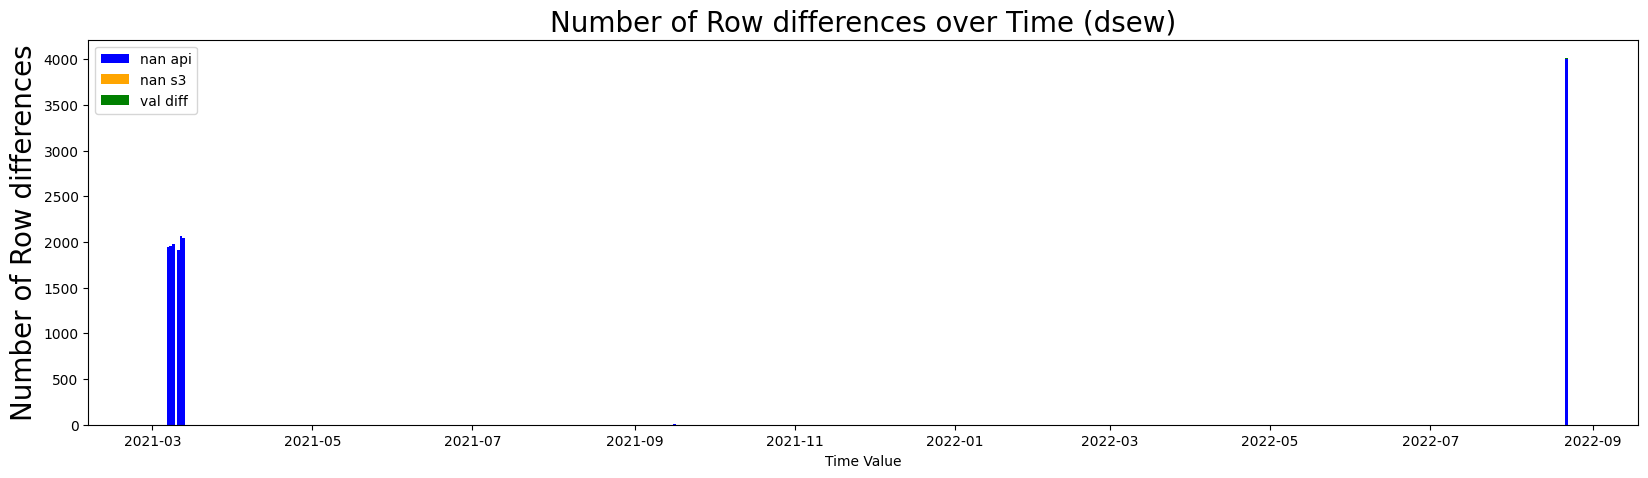

In [130]:
# Convert 'time_value' to datetime
dsew_diff['time_value'] = pd.to_datetime(dsew_diff['time_value'], format='%Y%m%d')
generate_diff_over_time_plot("dsew", dsew_diff)

#### 6. usafacts
Vast majority of files match.
Big spike for super brief periods of time in 2020.

In [ ]:
usafacts = df[df["source"]=="usa-facts"]

In [ ]:
print(f"Files with mismatched rows: {len(usafacts[usafacts['dif_row_count']!=0])}")
print(f"Files processed: {len(usafacts)}")
print(f"Rate of problematic files: {len(usafacts[usafacts['dif_row_count']!=0])/len(usafacts)}")

In [ ]:
usafacts_diff = usafacts[usafacts['dif_row_count']!=0]
usafacts_match = usafacts[usafacts['dif_row_count']==0]

generate_diff_plot("usa-facts", usafacts_match, usafacts_diff)

In [ ]:
# Convert 'time_value' to datetime
usafacts_diff['time_value'] = pd.to_datetime(usafacts_diff['time_value'], format='%Y%m%d')
generate_diff_over_time_plot("usa-facts", usafacts_diff)

#### 7. JHU
Around 20% of fies have mismatch. 
Big outlier spike in early 2023.

In [ ]:
jhu = df[df["source"]=="jhu-csse"]
jhu.head()

In [ ]:
print(len(jhu[jhu['dif_row_count']!=0]))
print(len(jhu))
print(len(jhu[jhu['dif_row_count']!=0])/len(jhu))

In [ ]:
jhu_diff = jhu[jhu['dif_row_count']!=0]
jhu_match = jhu[jhu['dif_row_count']==0]

generate_diff_plot("jhu", jhu_match, jhu_diff)

In [ ]:
# Convert 'time_value' to datetime
jhu_diff['time_value'] = pd.to_datetime(jhu_diff['time_value'], format='%Y%m%d')
generate_diff_over_time_plot("jhu", jhu_diff)